In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
## Load amygdala database
df = pd.read_csv('FCallSessions.csv')
# create a long format for analysis
df.describe()

,groupIdx,amg_hippPost1,amg_vmPFC1,amg_HippAnt1,amg_vmPFCAnt1,hippAnt_vmPFCAnt1,hippAnt_hippPost1,amg_hippPost2,amg_vmPFC2,amg_hippAnt2,amg_vmPFCAnt2,hippAnt_vmPFCAnt2,hippAnt_hippPost2,amg_hippPost3,amg_vmPFC3,amg_hippAnt3,amg_vmPFCAnt3,hippAnt_vmPFCAnt3,hippAnt_hippPost3
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.518519,0.285492,0.512272,0.269575,0.349221,0.213174,0.305449,0.286525,0.360390,0.306771,0.230139,0.242307,0.273948,0.338102,0.409253,0.271146,0.214985,0.178116,0.425026
std,0.509175,0.208424,0.221939,0.258476,0.218027,0.296783,0.251906,0.295561,0.215478,0.241151,0.226912,0.282460,0.259970,0.306003,0.219302,0.267546,0.292768,0.299988,0.193779
min,0.000000,-0.096844,-0.055699,-0.192782,-0.349564,-0.469990,-0.250251,-0.254465,-0.272251,-0.214743,-0.229349,-0.443330,-0.130521,-0.366046,-0.146157,-0.189834,-0.385748,-0.460460,-0.029337
25%,0.000000,0.134673,0.354129,0.143131,0.258047,0.094840,0.176490,0.043544,0.245561,0.094251,0.137181,0.134233,0.068577,0.143829,0.290851,0.094045,0.066558,0.014552,0.289250
50%,1.000000,0.281188,0.568741,0.258664,0.381235,0.232867,0.330019,0.356874,0.363085,0.351817,0.249799,0.271290,0.204436,0.309572,0.479818,0.301530,0.249703,0.176067,0.489939
75%,1.000000,0.443839,0.670424,0.392993,0.476364,0.392850,0.519965,0.539539,0.486812,0.497305,0.387631,0.427041,0.509306,0.567329,0.551353,0.448451,0.413853,0.458328,0.550105
max,1.000000,0.658449,0.774370,0.750596,0.646947,0.662831,0.648514,0.698112,0.675950,0.733511,0.584931,0.653689,0.848090,0.807860,0.753866,0.751112,0.740254,0.662622,0.694430


## Amygdala Hippocampus

In [13]:
#vars = ['amg_HippAnt1', 'amg_hippAnt2', 'amg_hippAnt3', 'amg_hippAnt4']
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_hippPost1','amg_hippPost2',
                                                                         'amg_hippPost3'])

In [14]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                          \
                       count      mean       std       min       25%   
groupIdx variable                                                      
0        amg_hippPost1  13.0  0.232713  0.156011  0.005189  0.108381   
         amg_hippPost2  12.0  0.438861  0.180178  0.073380  0.381203   
         amg_hippPost3  10.0  0.292109  0.357691 -0.366046  0.101157   
1        amg_hippPost1  14.0  0.334501  0.242985 -0.096844  0.172942   
         amg_hippPost2  14.0  0.155951  0.317396 -0.254465 -0.104551   
         amg_hippPost3  12.0  0.376429  0.265625 -0.131075  0.229355   

                                                      
                             50%       75%       max  
groupIdx variable                                     
0        amg_hippPost1  0.234275  0.332985  0.494981  
         amg_hippPost2  0.472924  0.578617  0.633108  
         amg_hippPost3  0.229846  0.567329  0.788340  
1        amg_hippPost1  0.353047  0.540697  0.658449  
         amg_hippPost2  0.078807  0.368853  0.698112  
         amg_hippPost3  0.396978  0.505380  0.807860

In [15]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        value   
No. Observations:          75             Method:                    REML    
No. Groups:                27             Scale:                     0.0608  
Min. group size:           2              Log-Likelihood:            -12.1202
Max. group size:           3              Converged:                 Yes     
Mean group size:           2.8                                               
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.233    0.072  3.232 0.001  0.092  0.374
variable[T.amg_hippPost2]           0.203    0.099  2.055 0.040  0.009  0.397
variable[T.amg_hippPost3]           0.058    0.104  0.560 0.576 -0.146  0.263
groupI

In [16]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.042      1     19  0.042  0.452    0.509  0.023  nan
variable     0.052      2     38  0.026  0.421    0.660  0.022    0.971
Interaction  0.263      2     38  0.132  2.146    0.131  0.101  nan



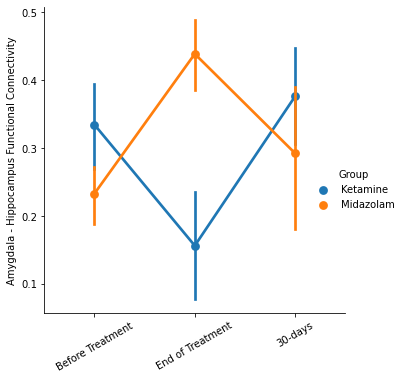

In [17]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - Hippocampus Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_postHipp_FC.png', dpi=300, bbox_inches='tight')

# Interaction model

In [20]:
df_long2 = pd.melt(df, id_vars=['scr_id','groupIdx', 'amg_hippPost1'], value_vars=['amg_hippPost2','amg_hippPost3'])
#df_long2

In [21]:
# take indexes for building the model
df_long2['scr_id'] = df_long2.scr_id.astype('category')
sub_idx = df_long2.scr_id.cat.codes.values 
print(sub_idx)
n_subs = len(np.unique(df_long2.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long2.variable = pd.Categorical(df_long2.variable, 
                    categories=['amg_hippPost2','amg_hippPost3'])
timeIDX = df_long2.variable.cat.codes.values
print(timeIDX)
df_long2['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26]
27
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [41]:
from utils import runModel

In [40]:
import importlib
importlib.reload(utils)

<module 'utils' from '/gpfs/ysm/home/oad4/KPE/func/fc/utils.py'>

In [42]:
trace = runModel(df_long2, 'amg_hippPost1', timeIDX)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


In [43]:
az.summary(trace, hdi_prob = .9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.026,0.088,-0.123,0.165,0.001,0.001,16133.0,6028.0,1.0
a[1],0.031,0.089,-0.116,0.177,0.001,0.001,20262.0,6069.0,1.0
a[2],0.020,0.094,-0.128,0.179,0.001,0.001,16430.0,5784.0,1.0
a[3],-0.032,0.091,-0.176,0.122,0.001,0.001,18269.0,5567.0,1.0
a[4],-0.022,0.088,-0.158,0.131,0.001,0.001,18854.0,5215.0,1.0
a[5],-0.003,0.092,-0.160,0.142,0.001,0.001,19000.0,5672.0,1.0
a[6],-0.016,0.095,-0.165,0.149,0.001,0.001,18196.0,6322.0,1.0
a[7],0.107,0.092,-0.038,0.261,0.001,0.001,16984.0,6018.0,1.0
a[8],-0.005,0.089,-0.146,0.142,0.001,0.001,18318.0,5654.0,1.0
a[9],0.009,0.092,-0.145,0.159,0.001,0.001,17309.0,5540.0,1.0


In [12]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)
   
    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX]

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=4000, tune=2000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

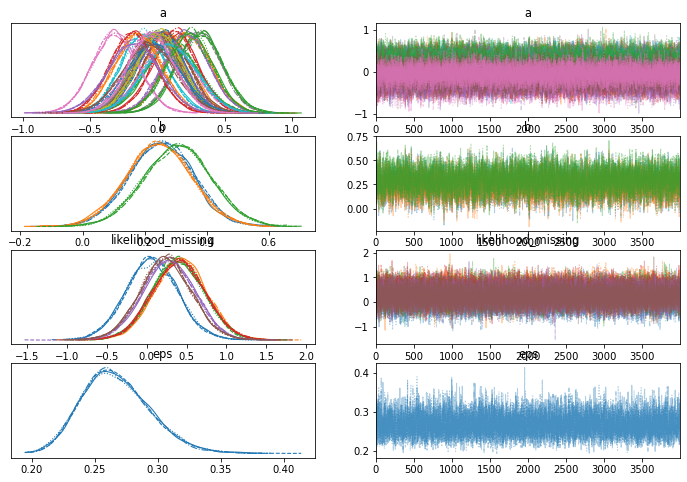

In [13]:
az.plot_trace(trace)

In [14]:
az.summary(trace, hdi_prob=.9)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.010,0.171,-0.294,0.265,0.002,0.001,8697.0,10449.0,1.0
a[1],0.065,0.169,-0.219,0.331,0.002,0.001,9018.0,10738.0,1.0
a[2],0.111,0.196,-0.215,0.427,0.002,0.001,8885.0,10397.0,1.0
a[3],0.019,0.170,-0.268,0.292,0.002,0.001,8816.0,11531.0,1.0
a[4],0.029,0.172,-0.242,0.322,0.002,0.001,8587.0,10637.0,1.0
a[5],0.059,0.172,-0.219,0.341,0.002,0.001,8554.0,10782.0,1.0
a[6],0.083,0.195,-0.242,0.399,0.002,0.001,9579.0,12356.0,1.0
a[7],0.305,0.170,0.026,0.582,0.002,0.001,8071.0,10012.0,1.0
a[8],-0.016,0.172,-0.305,0.257,0.002,0.001,8677.0,10816.0,1.0
a[9],-0.102,0.172,-0.379,0.185,0.002,0.001,8497.0,10692.0,1.0


0.461375


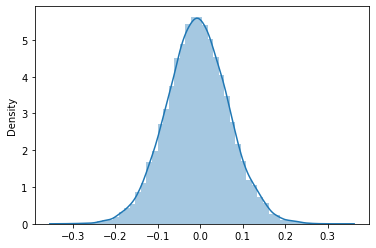

In [15]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

0.7539375


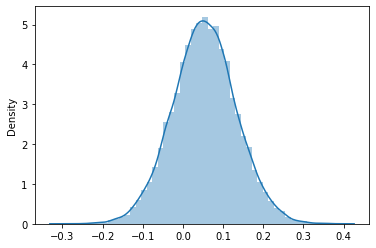

In [16]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [17]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.231,0.061,0.130,0.331,0.001,0.001,1953.0,1919.0,1.0
groupIdx,0.105,0.085,-0.033,0.245,0.002,0.001,2051.0,2262.0,1.0
sd,0.217,0.034,0.165,0.270,0.001,0.001,1866.0,1670.0,1.0


In [18]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.442,0.080,0.312,0.570,0.002,0.001,1506.0,1879.0,1.01
groupIdx,-0.285,0.112,-0.461,-0.101,0.003,0.002,1559.0,2152.0,1.01
sd,0.278,0.042,0.210,0.342,0.001,0.001,2017.0,1982.0,1.00


In [19]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.290,0.107,0.107,0.455,0.003,0.002,1678.0,1886.0,1.0
groupIdx,0.087,0.146,-0.140,0.333,0.004,0.003,1651.0,1763.0,1.0
sd,0.332,0.057,0.243,0.421,0.001,0.001,1975.0,1926.0,1.0


- Between amygdala and posterior hippocampus there's a difference only after treatment. With Ketamine shows lower connectivity, compared to midazolam.

## Amygdala and vmPFC

In [70]:
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_vmPFC1','amg_vmPFC2',
                                                                         'amg_vmPFC3'])

In [71]:
df_long.groupby(['groupIdx','variable']).describe()

value                                                    \
                    count      mean       std       min       25%       50%   
groupIdx variable                                                             
0        amg_vmPFC1  13.0  0.476762  0.232118 -0.055699  0.342115  0.523917   
         amg_vmPFC2  12.0  0.319887  0.228887 -0.272251  0.231635  0.344384   
         amg_vmPFC3  10.0  0.486395  0.153387  0.196863  0.432737  0.483726   
1        amg_vmPFC1  14.0  0.545246  0.215284 -0.009363  0.507766  0.603726   
         amg_vmPFC2  14.0  0.395107  0.205300  0.004965  0.276399  0.373607   
         amg_vmPFC3  12.0  0.344969  0.250293 -0.146157  0.263921  0.324898   

                                         
                          75%       max  
groupIdx variable                        
0        amg_vmPFC1  0.631171  0.774370  
         amg_vmPFC2  0.472607  0.615081  
         amg_vmPFC3  0.568808  0.753866  
1        amg_vmPFC1  0.673977  0.766076  
         amg_vmPFC2  0.565012  0.675950  
         amg_vmPFC3  0.526263  0.709229

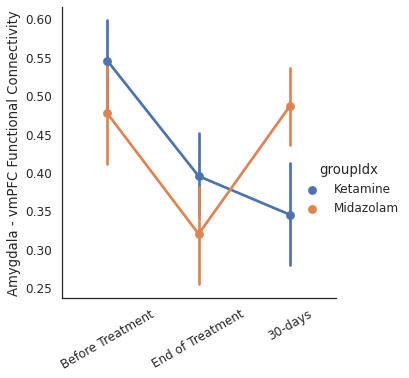

In [23]:
sns.set(font_scale = 1.1)
sns.set_style("white")
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point',
           ci=68, hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - vmPFC Functional Connectivity")
#g._legend.set_title("Group")
new_labels = ['Ketamine','Midazolam']
#leg = plt.legend(loc="upper right", frameon=False, fontsize=15, labels=new_labels)
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.savefig('amg_vmpfc_FC.png', dpi=600, bbox_inches='tight')

In [24]:
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.018      1     19  0.018  0.406    0.531  0.021  nan
variable     0.436      2     38  0.218  4.436    0.019  0.189    0.984
Interaction  0.140      2     38  0.070  1.419    0.254  0.070  nan



In [25]:
glm = smf.mixedlm('value ~ C(variable) * C(groupIdx)', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                        Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           value  
No. Observations:             75                Method:                       REML   
No. Groups:                   27                Scale:                        0.0471 
Min. group size:              2                 Log-Likelihood:               -0.3051
Max. group size:              3                 Converged:                    Yes    
Mean group size:              2.8                                                    
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.477    0.060  7.891 0.000  0.358  0.595
C(variable)[T.amg_vmPFC2]                  -0.157    0.087 -1.806 0.071 -0.328

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [72]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26]
27
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


In [73]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
# look at difference between before/after
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.068,0.151,-0.341,0.230,0.004,0.003,1503.0,2284.0,1.0
a[1],0.132,0.155,-0.177,0.404,0.004,0.003,1500.0,1969.0,1.0
a[2],0.023,0.177,-0.329,0.339,0.004,0.003,1650.0,2730.0,1.0
a[3],0.023,0.153,-0.265,0.308,0.004,0.003,1459.0,1846.0,1.0
a[4],0.259,0.156,-0.023,0.571,0.004,0.003,1556.0,2521.0,1.0
a[5],-0.061,0.150,-0.342,0.221,0.004,0.003,1644.0,2431.0,1.0
a[6],-0.008,0.172,-0.337,0.318,0.004,0.003,1795.0,2613.0,1.0
a[7],0.033,0.153,-0.241,0.330,0.004,0.003,1489.0,2129.0,1.0
a[8],0.083,0.154,-0.203,0.374,0.004,0.003,1576.0,2354.0,1.0
a[9],0.199,0.151,-0.090,0.477,0.004,0.003,1429.0,2453.0,1.0


<AxesSubplot:title={'center':'x'}>

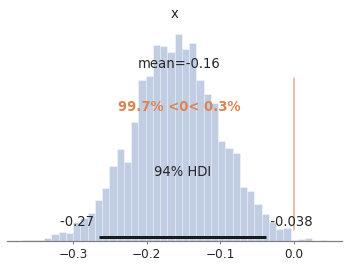

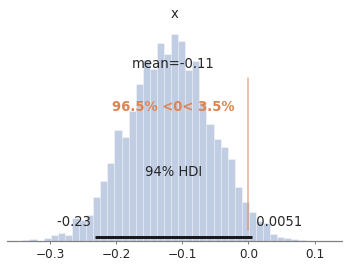

In [30]:
az.plot_posterior(trace['b'][:,1] - trace['b'][:,0], kind='hist',ref_val=0)
az.plot_posterior(trace['b'][:,2] - trace['b'][:,0], kind='hist',ref_val=0)

In [76]:
# an interaction model
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
    b = pm.Normal('b', mu=0, sd=0.1, shape=3)
    
    
   # bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=2) #
    interact = pm.Normal('interaction', mu=0, sd=0.1, shape=(3,2))
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + interact[timeIDX,df_long.groupIdx] 
    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    ppChecks = pm.sample_prior_predictive(samples = 2000)
    trace2 = pm.sample(draws=2000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, interaction, b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


In [77]:
az.summary(trace2, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.023,0.079,-0.155,0.104,0.001,0.001,18301.0,5846.0,1.0
a[1],0.063,0.079,-0.065,0.194,0.001,0.001,17646.0,5705.0,1.0
a[2],0.022,0.085,-0.118,0.161,0.001,0.001,15070.0,6205.0,1.0
a[3],0.020,0.079,-0.109,0.151,0.001,0.001,14901.0,5489.0,1.0
a[4],0.116,0.082,-0.023,0.247,0.001,0.001,17609.0,5886.0,1.0
a[5],-0.020,0.079,-0.153,0.108,0.001,0.001,16603.0,5605.0,1.0
a[6],-0.007,0.084,-0.152,0.124,0.001,0.001,14049.0,6191.0,1.0
a[7],0.020,0.079,-0.115,0.141,0.001,0.001,15702.0,6284.0,1.0
a[8],0.041,0.080,-0.094,0.168,0.001,0.001,17020.0,5243.0,1.0
a[9],0.090,0.077,-0.034,0.219,0.001,0.001,14430.0,6046.0,1.0


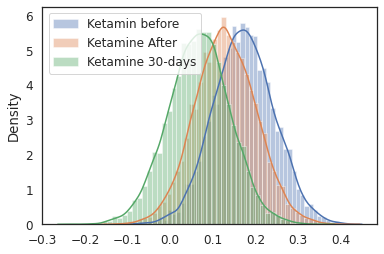

In [81]:
# compare 
tr = trace2.posterior.stack(draws=("chain", "draw"))
sns.distplot(tr.interaction.values[0,1,:,], label='Ketamin before')
sns.distplot(tr.interaction.values[1,1,:], label = 'Ketamine After')
sns.distplot(tr.interaction.values[2,1,:], label = 'Ketamine 30-days')
plt.legend()

3140.0


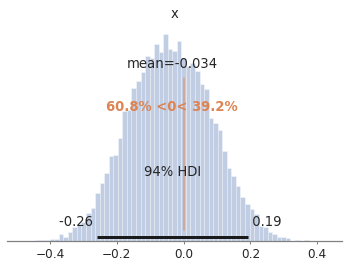

In [89]:
after = (tr.interaction.values[2,1,:,] - tr.interaction.values[0,1,:,])# / np.sqrt(
az.plot_posterior(after, kind='hist', ref_val=0)
print(np.sum(after>=0) / len(after))

0.642875


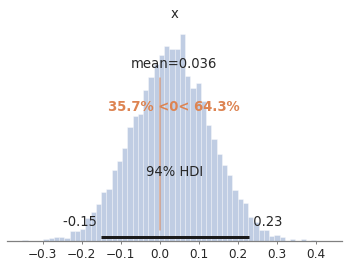

In [88]:
after = (tr.interaction.values[2,0,:,] - tr.interaction.values[0,0,:,])# / np.sqrt(
az.plot_posterior(after, kind='hist', ref_val=0)
print(np.sum(after>=0) / len(after))

0.28825


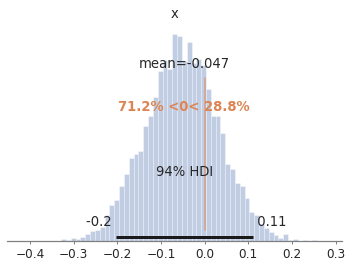

In [94]:
# mean across groups
after = (np.mean(tr.interaction.values[1,:,:,], axis=0) - np.mean(tr.interaction.values[0,:,:,], axis=0))# / np.sqrt(
az.plot_posterior(after, kind='hist', ref_val=0)
print(np.sum(after>=0) / len(after))

In [31]:
## Generate model with difference sampling as well
with pm.Model() as model2:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
    
    # adding sd for each 
    #sigma = pm.HalfNormal('sigma_before', .5, shape=3)
        
    b = pm.Normal('b', mu=0, sd=.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
 
    # difference between
    diff_of_means_bfrAftr = pm.Deterministic('differenceBfrAft', b[1] - b[0])
    diff_of_means_bfr30 = pm.Deterministic('differenceBfr30D', b[2] - b[0])
    # effect size
#     effect_size = pm.Deterministic('effect sizeBeforeAfter', 
#                         abs(diff_of_means_bfrAftr) / np.sqrt((sigma[0]**2 + sigma[1]**2) / 2))
    
    trace_diffs = pm.sample(draws=1000, tune=1000, target_accept=0.9, return_inferencedata=False)
    prior_checks = pm.sample_prior_predictive(samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [32]:
az.summary(trace_diffs)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.065,0.153,-0.353,0.220,0.004,0.003,1452.0,1775.0,1.00
a[1],0.139,0.153,-0.144,0.431,0.004,0.003,1586.0,2366.0,1.00
a[2],0.023,0.174,-0.324,0.338,0.004,0.003,2002.0,2823.0,1.00
a[3],0.025,0.154,-0.258,0.307,0.004,0.003,1563.0,2117.0,1.00
a[4],0.263,0.153,-0.032,0.544,0.004,0.003,1512.0,2304.0,1.00
a[5],-0.056,0.150,-0.356,0.210,0.004,0.003,1648.0,2014.0,1.00
a[6],-0.005,0.172,-0.335,0.305,0.004,0.003,2010.0,2705.0,1.00
a[7],0.037,0.152,-0.246,0.319,0.004,0.003,1507.0,2024.0,1.00
a[8],0.083,0.153,-0.193,0.381,0.004,0.003,1474.0,2160.0,1.00
a[9],0.201,0.148,-0.080,0.470,0.004,0.003,1603.0,2444.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'b\n0'}>,
        <AxesSubplot:title={'center':'b\n1'}>,
        <AxesSubplot:title={'center':'b\n2'}>],
       [<AxesSubplot:title={'center':'differenceBfrAft'}>,
        <AxesSubplot:title={'center':'differenceBfr30D'}>,
        <AxesSubplot:>]], dtype=object)

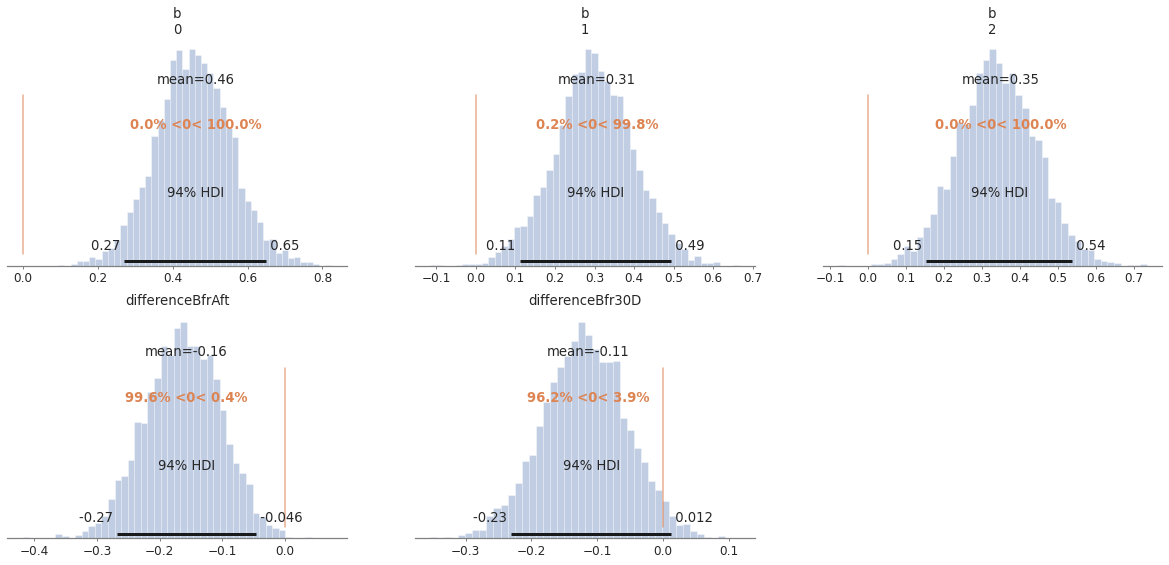

In [33]:
az.plot_posterior(trace_diffs, var_names=['b','differenceBfrAft','differenceBfr30D'], ref_val=0,
                 kind='hist')

In [32]:
az.summary(trace, hdi_prob=.9)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.070,0.152,-0.321,0.171,0.004,0.003,1314.0,2043.0,1.00
a[1],0.131,0.154,-0.108,0.397,0.004,0.003,1477.0,2209.0,1.00
a[2],0.017,0.173,-0.258,0.312,0.004,0.003,1787.0,2646.0,1.00
a[3],0.018,0.150,-0.219,0.269,0.004,0.003,1359.0,2351.0,1.00
a[4],0.256,0.150,0.022,0.511,0.004,0.003,1507.0,2168.0,1.00
a[5],-0.061,0.150,-0.298,0.189,0.004,0.003,1432.0,2292.0,1.00
a[6],-0.014,0.170,-0.324,0.234,0.004,0.003,1987.0,3116.0,1.00
a[7],0.031,0.150,-0.207,0.286,0.004,0.003,1514.0,2098.0,1.00
a[8],0.079,0.154,-0.171,0.328,0.004,0.003,1486.0,2150.0,1.00
a[9],0.197,0.150,-0.042,0.449,0.004,0.003,1507.0,2327.0,1.00


<AxesSubplot:ylabel='Density'>

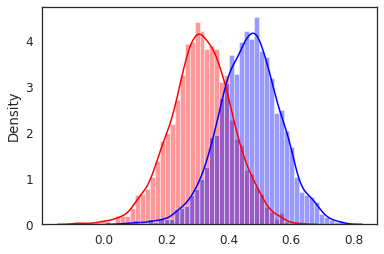

In [96]:
## what are the chances that amygdala-vmpfc connectivity was higher given the current data
sns.distplot(trace['b'][:,1], color='red')
#sns.distplot(trace['b'][500:,2], color = 'maroon')
sns.distplot(trace['b'][:,0], color='blue')


In [97]:
# calculating the overlap between the two distributions
y2 = trace['b'][:,0]
y1 = trace['b'][:,1]
from scipy import stats

xmin, xmax = -4., 4.
x_pts = np.mgrid[xmin:xmax:4000]


ker_b = stats.gaussian_kde(y1)
ker_a = stats.gaussian_kde(y2)
kde_a = np.reshape(ker_a(x_pts).T, x_pts.shape)
kde_b = np.reshape(ker_b(x_pts).T, x_pts.shape)


# Random sample from a KDE distribution.
sample = ker_a.resample(size=3000)

# Compute the points below which to integrate.
iso = ker_b(sample)

# Filter the sample.
insample = ker_a(sample) < iso

# As per Monte Carlo, the integral is equivalent to the
# probability of drawing a point that gets through the
# filter.
integral = float(insample.shape[0]) / insample.sum()  

integral


4.746835443037975

sns.distplot(sample)
sns.distplot(y1)
#sns.distplot(iso)
insample

0.003


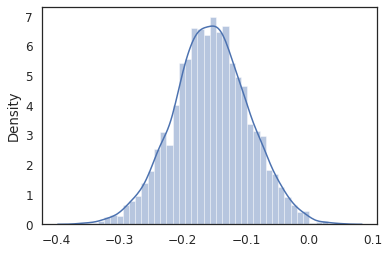

In [36]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

0.03475


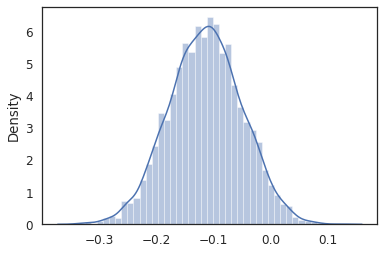

In [37]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

Differences between groups

In [38]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8791182580058777, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807856740308598, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.475,0.066,0.363,0.581,0.002,0.001,1794.0,2154.0,1.0
groupIdx,0.071,0.093,-0.078,0.229,0.002,0.002,1917.0,1848.0,1.0
sd,0.236,0.036,0.181,0.294,0.001,0.001,2043.0,1954.0,1.0


In [39]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.7133907906725843, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.320,0.065,0.211,0.421,0.002,0.001,1590.0,2074.0,1.0
groupIdx,0.075,0.090,-0.071,0.219,0.002,0.002,1627.0,1967.0,1.0
sd,0.228,0.035,0.175,0.284,0.001,0.001,1938.0,1653.0,1.0


In [40]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.487,0.075,0.358,0.599,0.002,0.001,1510.0,1730.0,1.0
groupIdx,-0.141,0.100,-0.306,0.017,0.003,0.002,1562.0,1926.0,1.0
sd,0.227,0.040,0.167,0.289,0.001,0.001,1757.0,1526.0,1.0


- Adding testing of declind within group and between time periods

In [41]:
# Just midazolam
df_longM = df_long[df_long.groupIdx==0]
glm = smf.mixedlm('value ~ variable', data=df_longM, groups = df_longM.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     value 
No. Observations:      35          Method:                 REML  
No. Groups:            13          Scale:                  0.0418
Min. group size:       2           Log-Likelihood:         0.6520
Max. group size:       3           Converged:              Yes   
Mean group size:       2.7                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.477    0.059  8.117 0.000  0.362  0.592
variable[T.amg_vmPFC2] -0.159    0.082 -1.932 0.053 -0.319  0.002
variable[T.amg_vmPFC3]  0.006    0.087  0.070 0.945 -0.164  0.176
Group Var               0.003    0.050                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [42]:
# Just Ketamine
df_longK = df_long[df_long.groupIdx==1]
glm = smf.mixedlm('value ~ variable', data=df_longK, groups = df_longK.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value  
No. Observations:     40          Method:                 REML   
No. Groups:           14          Scale:                  0.0497 
Min. group size:      2           Log-Likelihood:         -0.8564
Max. group size:      3           Converged:              Yes    
Mean group size:      2.9                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.545    0.060  9.150 0.000  0.428  0.662
variable[T.amg_vmPFC2] -0.150    0.084 -1.781 0.075 -0.315  0.015
variable[T.amg_vmPFC3] -0.200    0.088 -2.283 0.022 -0.372 -0.028
Group Var               0.000    0.039                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [53]:
# lets test the 30 days vs. before trt
#pg.ttest(df.amg_vmPFC1[df.groupIdx==0], df.amg_vmPFC3[df.groupIdx==0])
pg.ttest(df.amg_vmPFC1[df.groupIdx==0], df.amg_vmPFC3[df.groupIdx==0], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.799741,9,two-sided,0.444455,"[-0.09, 0.2]",0.304903,0.403,0.139044


In [52]:
pg.ttest(df.amg_vmPFC1[df.groupIdx==1], df.amg_vmPFC3[df.groupIdx==1], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.782662,11,two-sided,0.102227,"[-0.05, 0.45]",0.833364,0.973,0.748124


In [55]:
## Same but Bayes
# generate two different data sets
def runBayes(df):
    
    df['scr_id'] = df.scr_id.astype('category')
    sub_idx = df.scr_id.cat.codes.values # 
    print(sub_idx)
    n_subs = len(np.unique(df.scr_id))
    print(n_subs)
    # set time as index also
    #df_long.groupIdx = pd.Categorical(df_long.groupIdx)
    df.variable = pd.Categorical(df.variable, 
                        categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
    timeIDX = df.variable.cat.codes.values
    print(timeIDX)
    df['time'] = timeIDX
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)

        b = pm.Normal('b', mu=0, sd=0.5, shape=3)
     
        eps = pm.HalfCauchy('eps', 3)

        y_hat = a[sub_idx] + b[timeIDX] 

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df.value)

        trace = pm.sample(draws=1000, tune=2000, target_accept=0.9, return_inferencedata=False)
    return trace

In [59]:
df_longMR = df_longM.reset_index(drop=True) # need to reset the indices

df_longMR.scr_id.cat.values
traceM = runBayes(df_longMR)

AttributeError: 'CategoricalAccessor' object has no attribute 'values'

In [57]:
df_longMR['scr_id'] = df_longMR.scr_id.astype('category')
df_longMR.scr_id.cat.codes

0      2
1      3
2     10
3     11
4     12
5     13
6     15
7     16
8     19
9     20
10    22
11    24
12    26
13     2
14     3
15    10
16    11
17    12
18    13
19    15
20    16
21    19
22    20
23    22
24    24
25    26
26     2
27     3
28    10
29    11
30    12
31    13
32    15
33    16
34    19
35    20
36    22
37    24
38    26
dtype: int8

In [58]:
diff = traceM['b'][:,1] - traceM['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

NameError: name 'traceM' is not defined

In [37]:
# same for K
df_longKR = df_longK.reset_index(drop=True) # need to reset the indices
df_longKR
traceK = runBayes(df_longKR)

[ 0  1  4  5  6  7  8 13 16 17 20 22 24  0  1  4  5  6  7  8 13 16 17 20
 22 24  0  1  4  5  6  7  8 13 16 17 20 22 24]
13
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2]


IndexError: index 13 is out of bounds for axis 0 with size 13

0.02375


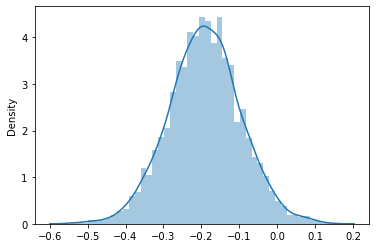

In [94]:
diff = traceK['b'][:,2] - traceK['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

## Amygdala anterior hippocampus

In [60]:
#vars = ['amg_HippAnt1', 'amg_hippAnt2', 'amg_hippAnt3', 'amg_hippAnt4']
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_HippAnt1','amg_hippAnt2',
                                                                         'amg_hippAnt3'])

In [61]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                                    \
                      count      mean       std       min       25%       50%   
groupIdx variable                                                               
0        amg_HippAnt1  13.0  0.214479  0.273074 -0.188385  0.123616  0.190337   
         amg_hippAnt2  12.0  0.299227  0.242692 -0.090673  0.090065  0.312811   
         amg_hippAnt3  10.0  0.205291  0.291547 -0.189834 -0.007372  0.195007   
1        amg_HippAnt1  14.0  0.320736  0.242758 -0.192782  0.208399  0.308021   
         amg_hippAnt2  14.0  0.313237  0.248794 -0.214743  0.118986  0.383952   
         amg_hippAnt3  12.0  0.326026  0.244706 -0.037593  0.125349  0.326469   

                                           
                            75%       max  
groupIdx variable                          
0        amg_HippAnt1  0.363448  0.750596  
         amg_hippAnt2  0.429742  0.733511  
         amg_hippAnt3  0.430613  0.657238  
1        amg_HippAnt1  0.393543  0.730621  
         amg_hippAnt2  0.517117  0.609480  
         amg_hippAnt3  0.484287  0.751112

In [62]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        value   
No. Observations:         75             Method:                    REML    
No. Groups:               27             Scale:                     0.0582  
Min. group size:          2              Log-Likelihood:            -11.2023
Max. group size:          3              Converged:                 Yes     
Mean group size:          2.8                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.214    0.071  3.014 0.003  0.075  0.354
variable[T.amg_hippAnt2]           0.078    0.097  0.802 0.423 -0.112  0.268
variable[T.amg_hippAnt3]          -0.008    0.102 -0.082 0.935 -0.209  0.192
groupIdx           

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [63]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.051      1     19  0.051  0.716    0.408  0.036  nan
variable     0.001      2     38  0.001  0.012    0.988  0.001    0.994
Interaction  0.009      2     38  0.005  0.073    0.930  0.004  nan



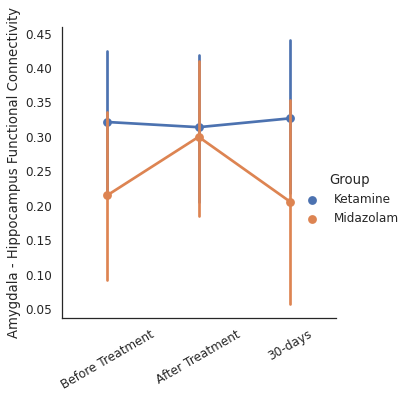

In [64]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=90,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "After Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - Hippocampus Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [18]:
pg.ttest(df.amg_hippAnt2[df.groupIdx==1], df.amg_hippAnt2[df.groupIdx==0], correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.336074,23,two-sided,0.739862,"[-0.17, 0.24]",0.134537,0.384,0.061981


In [65]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_HippAnt1','amg_hippAnt2','amg_hippAnt3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26]
27
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


In [66]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    traceamgAntHipp = pm.sample(draws=2000, tune=2000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
az.summary(traceamgAntHipp,hdi_prob=0.9 )

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.069,0.158,-0.324,0.197,0.003,0.002,3383.0,5143.0,1.0
a[1],-0.073,0.159,-0.353,0.174,0.003,0.002,3147.0,4679.0,1.0
a[2],-0.221,0.182,-0.522,0.073,0.003,0.002,3614.0,5235.0,1.0
a[3],0.070,0.161,-0.194,0.334,0.003,0.002,2917.0,4664.0,1.0
a[4],0.128,0.163,-0.151,0.385,0.003,0.002,3231.0,4982.0,1.0
a[5],-0.098,0.159,-0.362,0.165,0.003,0.002,3175.0,4734.0,1.0
a[6],0.105,0.159,-0.169,0.352,0.003,0.002,3448.0,4925.0,1.0
a[7],0.259,0.158,0.002,0.516,0.003,0.002,3173.0,5209.0,1.0
a[8],0.146,0.159,-0.113,0.410,0.003,0.002,3261.0,5345.0,1.0
a[9],-0.328,0.159,-0.580,-0.062,0.003,0.002,3246.0,5339.0,1.0


0.666


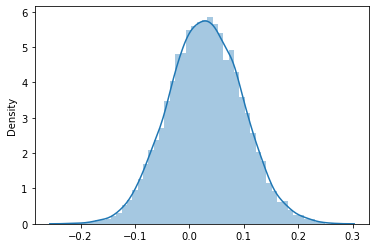

In [14]:
diff = traceamgAntHipp['b'][:,1] - traceamgAntHipp['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

0.508


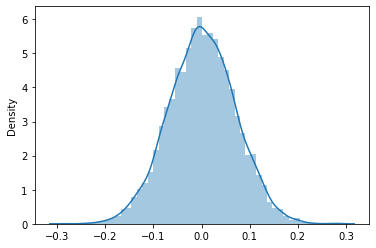

In [15]:
diff = traceamgAntHipp['b'][:,2] - traceamgAntHipp['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [67]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_HippAnt1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.214,0.079,0.089,0.348,0.002,0.001,1872.0,2068.0,1.0
groupIdx,0.106,0.109,-0.078,0.273,0.002,0.002,1902.0,1750.0,1.0
sd,0.270,0.040,0.203,0.327,0.001,0.001,2149.0,1634.0,1.0


In [68]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippAnt2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.297,0.078,0.173,0.429,0.002,0.001,1673.0,1954.0,1.0
groupIdx,0.016,0.104,-0.160,0.186,0.003,0.002,1632.0,1969.0,1.0
sd,0.262,0.041,0.193,0.321,0.001,0.001,2077.0,1926.0,1.0


In [69]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippAnt3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8981718794973501, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.206,0.095,0.057,0.365,0.002,0.002,1904.0,1751.0,1.0
groupIdx,0.117,0.128,-0.089,0.331,0.003,0.002,1930.0,1992.0,1.0
sd,0.287,0.051,0.210,0.362,0.001,0.001,1822.0,2033.0,1.0
